**Machine Learning Engineer Nanodegree Capstone  
Donia Robinson  
KDD Cup 2010 Educational Data Mining Challenge**

***

## Analysis: Data Exploration

In [27]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.externals import joblib
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# smaller dataset, with less features, that I used for some initial testing
#current_set = 'algebra_2005_2006'

current_set = 'algebra_2008_2009'
filetoload = "datasets/" + current_set + "/" + current_set

# Load training dataset
try:
    data_train = pd.read_table(filetoload + "_train.txt")
    print current_set + " training set has {} samples with {} features each.".format(*data_train.shape)
except:
    print current_set + " training set could not be loaded."

# save number of records found in training set
num_train_records = data_train.shape[0]


# Load testing dataset
try:
    data_test = pd.read_table(filetoload + "_test.txt")
    print current_set + " testing set has {} samples with {} features each.".format(*data_test.shape)
except:
    print current_set + " testing set could not be loaded."

# save number of records found in testing set
num_test_records = data_test.shape[0]

algebra_2008_2009 training set has 8918054 samples with 23 features each.
algebra_2008_2009 testing set has 508912 samples with 23 features each.


In [3]:
def make_sampleframe(data):
    # Indices to sample from the dataset
    indices = [100,101,102,5000000,5000001,5000002]    

    samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
    return samples

In [4]:
# Let's take a look at all of the features that were read in and begin to think about which ones won't be needed, which ones might need to be pre-processed, etc.
print "Samples of steps from " + current_set + " training set:"
display(make_sampleframe(data_train))

Samples of steps from algebra_2008_2009 training set:


,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,...,Correct First Attempt,Incorrects,Hints,Corrects,KC(SubSkills),Opportunity(SubSkills),KC(KTracedSkills),Opportunity(KTracedSkills),KC(Rules),Opportunity(Rules)
0,101,stu_de2777346f,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-056,1,SelectFractionsquare centimeterssquare meters,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,...,1,1,0,1,Select form of one with numerator of one,4,Select form of one with numerator of one-1,4,UNIT-CONVERSION-SELECT-FRACTION-GOAL-NODE-Cond...,10
1,102,stu_de2777346f,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-056,1,Numerator,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,...,1,0,0,1,Enter numerator of converted unit,10,NaN,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-DEFAULT-HINTS,2
2,103,stu_de2777346f,"Unit UNIT-CONVERSIONS-ONE-STEP, Section UNIT-C...",UNITCONVERSION1-056,1,Denominator,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,2008-09-24 14:29:45.0,...,1,0,0,1,Enter denominator of converted unit,10,NaN,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-HINTS-PARTN...,2
3,5000001,stu_16107494d9,"Unit CTA1_02, Section CTA1_02-4",REAL19,1,R6C2,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,...,1,0,0,1,"Using simple numbers~~Find Y, any form~~Using ...",99~~66~~42~~14,Using simple numbers-1~~Using large numbers-1~...,99~~42~~14,CALCULATED-VALUE-MX+B-GIVEN-X-SLOPE-NEGATIVE,12
4,5000002,stu_16107494d9,"Unit CTA1_02, Section CTA1_02-4",REAL19,1,R7C1,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,...,1,0,0,1,"Enter given, reading numerals~~Entering a given",26~~9,NaN,NaN,GIVEN-HELP-DONT-REPEAT-UNIT,25
5,5000003,stu_16107494d9,"Unit CTA1_02, Section CTA1_02-4",REAL19,1,R7C2,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,2008-10-10 16:47:45.0,...,1,0,0,1,"Using simple numbers~~Find Y, any form~~Using ...",100~~67~~43~~15,Using simple numbers-1~~Using large numbers-1~...,100~~43~~15,CALCULATED-VALUE-USE-THE-GRAPH,12


## Feature Discussion

In [5]:
data_trimmed_train = data_train.copy()
data_trimmed_test = data_test.copy()

# in the test portion of the challenge sets in the competition, several features are not provided,
# so it is important that my algorithm not rely on these to make predictions

not_used = ['Row', 'Anon Student Id', 'Problem Hierarchy', 'Problem View', 'Step Start Time',\
            'First Transaction Time', 'Correct Transaction Time', 'Step End Time', 'Step Duration (sec)',\
            'Correct Step Duration (sec)', 'Error Step Duration (sec)', 'Incorrects', 'Hints', 'Corrects',\
            'Opportunity(SubSkills)','Opportunity(KTracedSkills)','Opportunity(Rules)']

data_trimmed_train.drop(not_used, axis = 1, inplace = True)
data_trimmed_test.drop(not_used, axis = 1, inplace = True)

print "Trimmed samples of steps from current dataset:"
display(make_sampleframe(data_trimmed_train))

Trimmed samples of steps from current dataset:


,Problem Name,Step Name,Correct First Attempt,KC(SubSkills),KC(KTracedSkills),KC(Rules)
0,UNITCONVERSION1-056,SelectFractionsquare centimeterssquare meters,1,Select form of one with numerator of one,Select form of one with numerator of one-1,UNIT-CONVERSION-SELECT-FRACTION-GOAL-NODE-Cond...
1,UNITCONVERSION1-056,Numerator,1,Enter numerator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-DEFAULT-HINTS
2,UNITCONVERSION1-056,Denominator,1,Enter denominator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-HINTS-PARTN...
3,REAL19,R6C2,1,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-MX+B-GIVEN-X-SLOPE-NEGATIVE
4,REAL19,R7C1,1,"Enter given, reading numerals~~Entering a given",NaN,GIVEN-HELP-DONT-REPEAT-UNIT
5,REAL19,R7C2,1,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-USE-THE-GRAPH


### Relevant Statistics

In [6]:
# Let's get an idea of how students did on their first try
correct_first_attempts = data_trimmed_train['Correct First Attempt'].value_counts()[1]
incorrect_first_attempts = data_trimmed_train['Correct First Attempt'].value_counts()[0]

correct_decimal = 1.00 * correct_first_attempts / num_train_records
pos_weight_train = float("{0:.3f}".format(correct_decimal))
neg_weight_train = float("{0:.3f}".format(1.00 - pos_weight_train))

correct_f_a_percent = 100.00 * correct_decimal
correct_int = int(100*correct_decimal)

# Print the results
print "Number of correct first attempts: {}".format(correct_first_attempts)
print "Number of incorrect first attempts: {}".format(incorrect_first_attempts)
print "Total number of attempts: {}".format(num_train_records)
print "Percentage of correct first attempts: {:.2f}%".format(correct_f_a_percent)

Number of correct first attempts: 7614730
Number of incorrect first attempts: 1303324
Total number of attempts: 8918054
Percentage of correct first attempts: 85.39%


### Data Abnormalities

In [7]:
print "Trimmed samples of steps from current dataset:"
display(make_sampleframe(data_trimmed_train))

Trimmed samples of steps from current dataset:


,Problem Name,Step Name,Correct First Attempt,KC(SubSkills),KC(KTracedSkills),KC(Rules)
0,UNITCONVERSION1-056,SelectFractionsquare centimeterssquare meters,1,Select form of one with numerator of one,Select form of one with numerator of one-1,UNIT-CONVERSION-SELECT-FRACTION-GOAL-NODE-Cond...
1,UNITCONVERSION1-056,Numerator,1,Enter numerator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-DEFAULT-HINTS
2,UNITCONVERSION1-056,Denominator,1,Enter denominator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-HINTS-PARTN...
3,REAL19,R6C2,1,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-MX+B-GIVEN-X-SLOPE-NEGATIVE
4,REAL19,R7C1,1,"Enter given, reading numerals~~Entering a given",NaN,GIVEN-HELP-DONT-REPEAT-UNIT
5,REAL19,R7C2,1,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-USE-THE-GRAPH


In [8]:
# determine what proportion of each column is comprised of NaN values; 
# this may help determine which features are most useful
data_trimmed_train.isnull().mean()

Problem Name             0.000000
Step Name                0.000000
Correct First Attempt    0.000000
KC(SubSkills)            0.277630
KC(KTracedSkills)        0.504409
KC(Rules)                0.036112
dtype: float64

***

***

## Methodology: Data Preprocessing

In [9]:
print "Distinct values of each feature:\n"

for column in data_trimmed_train.columns:
    print(column + ": " + str(data_trimmed_train[column].nunique()))

Distinct values of each feature:

Problem Name: 188368
Step Name: 700635
Correct First Attempt: 2
KC(SubSkills): 1828
KC(KTracedSkills): 921
KC(Rules): 2978


In [10]:
# concatenate train and test sets so that TruncatedSVD and kmeans can occur on all rows at the same time
data_full = pd.concat([data_trimmed_train, data_trimmed_test]).reset_index(drop=True)
num_all_records = data_full.shape[0]
print "Number of records in combined testing and training set: %i" % num_all_records

print "Trimmed samples of steps from current dataset:"
display(make_sampleframe(data_full))

Number of records in combined testing and training set: 9426966
Trimmed samples of steps from current dataset:


,Problem Name,Step Name,Correct First Attempt,KC(SubSkills),KC(KTracedSkills),KC(Rules)
0,UNITCONVERSION1-056,SelectFractionsquare centimeterssquare meters,1.0,Select form of one with numerator of one,Select form of one with numerator of one-1,UNIT-CONVERSION-SELECT-FRACTION-GOAL-NODE-Cond...
1,UNITCONVERSION1-056,Numerator,1.0,Enter numerator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-DEFAULT-HINTS
2,UNITCONVERSION1-056,Denominator,1.0,Enter denominator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-HINTS-PARTN...
3,REAL19,R6C2,1.0,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-MX+B-GIVEN-X-SLOPE-NEGATIVE
4,REAL19,R7C1,1.0,"Enter given, reading numerals~~Entering a given",NaN,GIVEN-HELP-DONT-REPEAT-UNIT
5,REAL19,R7C2,1.0,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-USE-THE-GRAPH


***

***

**Cluster and convert feature text values to numerical categories**

In [11]:
# ANCHOR; load in the data structure that has been saved to a file

print "start loading file"
filename = 'data/features.txt'
data_saved_orig = joblib.load(filename)
print "done loading file"

start loading file
done loading file


**Cluster and convert Problem Name text values to numerical categories**

In [12]:
#%%writefile f_problemname.py
# %load f_problemname.py

**Cluster and convert Step Name text values to numerical categories**

In [13]:
#%%writefile f_stepname.py
# %load f_stepname.py

**Cluster and convert KC(SubSkills) text values to numerical categories**

In [14]:
#%%writefile f_ksubskills.py
# %load f_ksubskills.py

**Cluster and convert KC(KTracedSkills) text values to numerical categories**

In [15]:
#%%writefile f_ktracedskills.py
# %load f_ktracedskills.py

**Cluster and convert KC(Rules) text values to numerical categories**

In [16]:
#%%writefile f_krules.py
# %load f_krules.py

**Demonstration of Kmeans with a small set and small number for K**

***

***

In [17]:
data_tmp = data_saved_orig.copy()

# print samples just to double-check file loaded in as expected
print "Samples from current dataset, now with number categories:"
display(make_sampleframe(data_tmp))

Samples from current dataset, now with number categories:


,Problem Name,Step Name,Correct First Attempt,KC(SubSkills),KC(KTracedSkills),KC(Rules),Problem Name Cat k200,Step Name k200,KC(SubSkills) k200,KC(KTracedSkills) k200,KC(Rules) k200,KC(Rules) k100,Step Name k100,Problem Name Cat k100,KC(KTracedSkills) k100,KC(SubSkills) k100
0,UNITCONVERSION1-056,SelectFractionsquare centimeterssquare meters,1.0,Select form of one with numerator of one,Select form of one with numerator of one-1,UNIT-CONVERSION-SELECT-FRACTION-GOAL-NODE-Cond...,28,161,115,129,19,92,61,7,19,12
1,UNITCONVERSION1-056,Numerator,1.0,Enter numerator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-DEFAULT-HINTS,28,109,5,1,100,40,73,7,1,38
2,UNITCONVERSION1-056,Denominator,1.0,Enter denominator of converted unit,NaN,UNIT-CONVERSION-FRACTION-COMPONENT-HINTS-PARTN...,28,132,117,1,97,99,68,7,1,38
3,REAL19,R6C2,1.0,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-MX+B-GIVEN-X-SLOPE-NEGATIVE,113,128,129,3,40,96,38,56,3,46
4,REAL19,R7C1,1.0,"Enter given, reading numerals~~Entering a given",NaN,GIVEN-HELP-DONT-REPEAT-UNIT,113,49,2,1,1,10,29,56,1,4
5,REAL19,R7C2,1.0,"Using simple numbers~~Find Y, any form~~Using ...",Using simple numbers-1~~Using large numbers-1~...,CALCULATED-VALUE-USE-THE-GRAPH,113,24,129,3,35,34,24,56,3,46


In [18]:
# currently the training and testing datasets given by the competition are together
# in the data structure; time to separate them out again

data_train_loaded = data_saved_orig[0:num_train_records]
print data_train_loaded.shape[0]

data_test_loaded = data_saved_orig[num_train_records:]
print data_test_loaded.shape[0]

8918054
508912


## Analysis: Exploratory Visualization

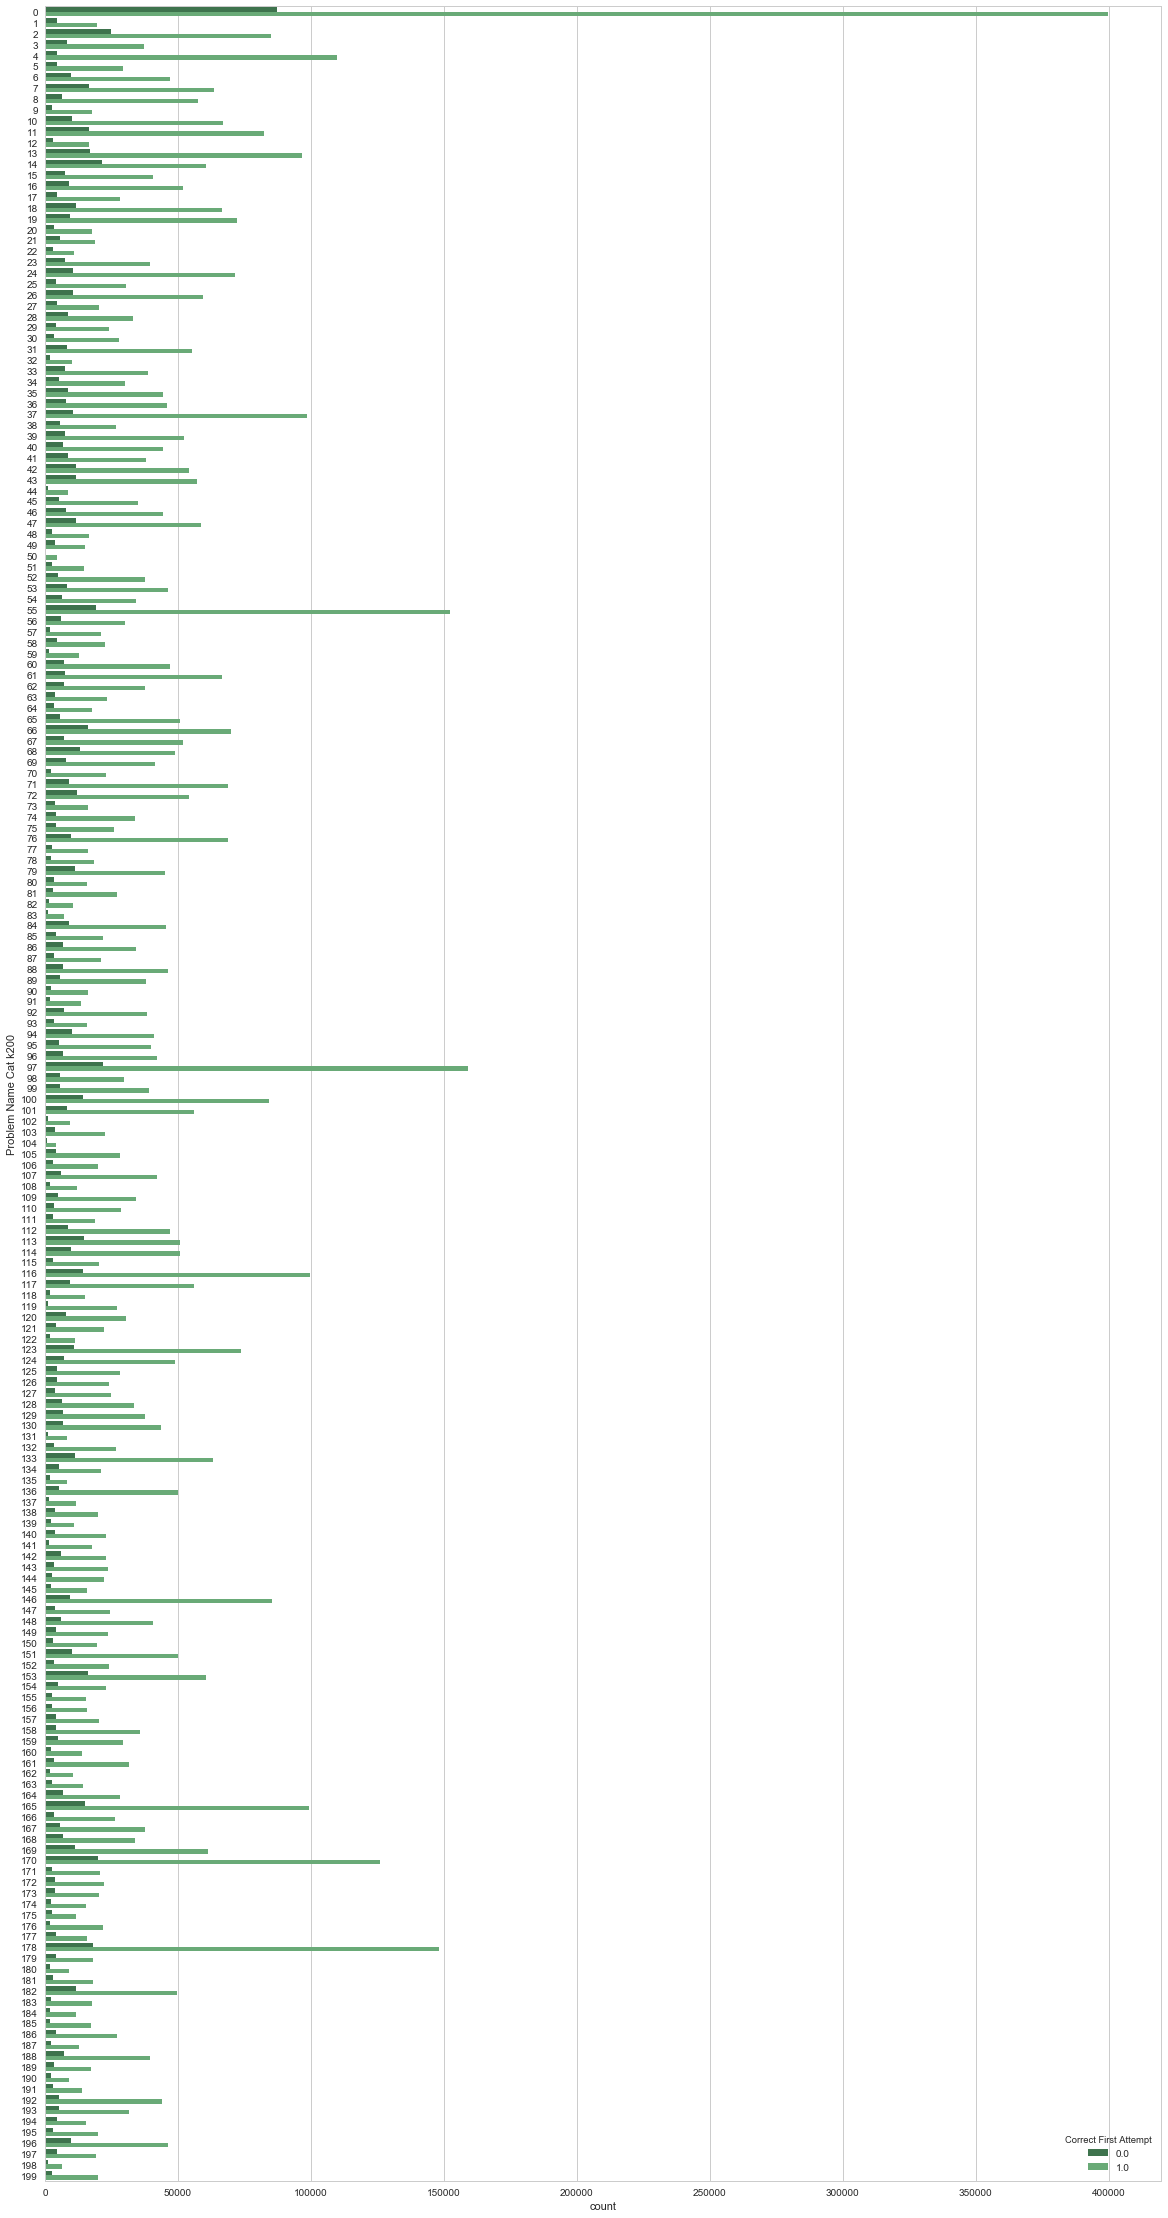

In [19]:
import seaborn as sns

sns.set(style="whitegrid", color_codes=True)

f, ax = plt.subplots(figsize=(20, 40))
sns.countplot(y="Problem Name Cat k200", hue="Correct First Attempt", data=data_train_loaded, palette="Greens_d");

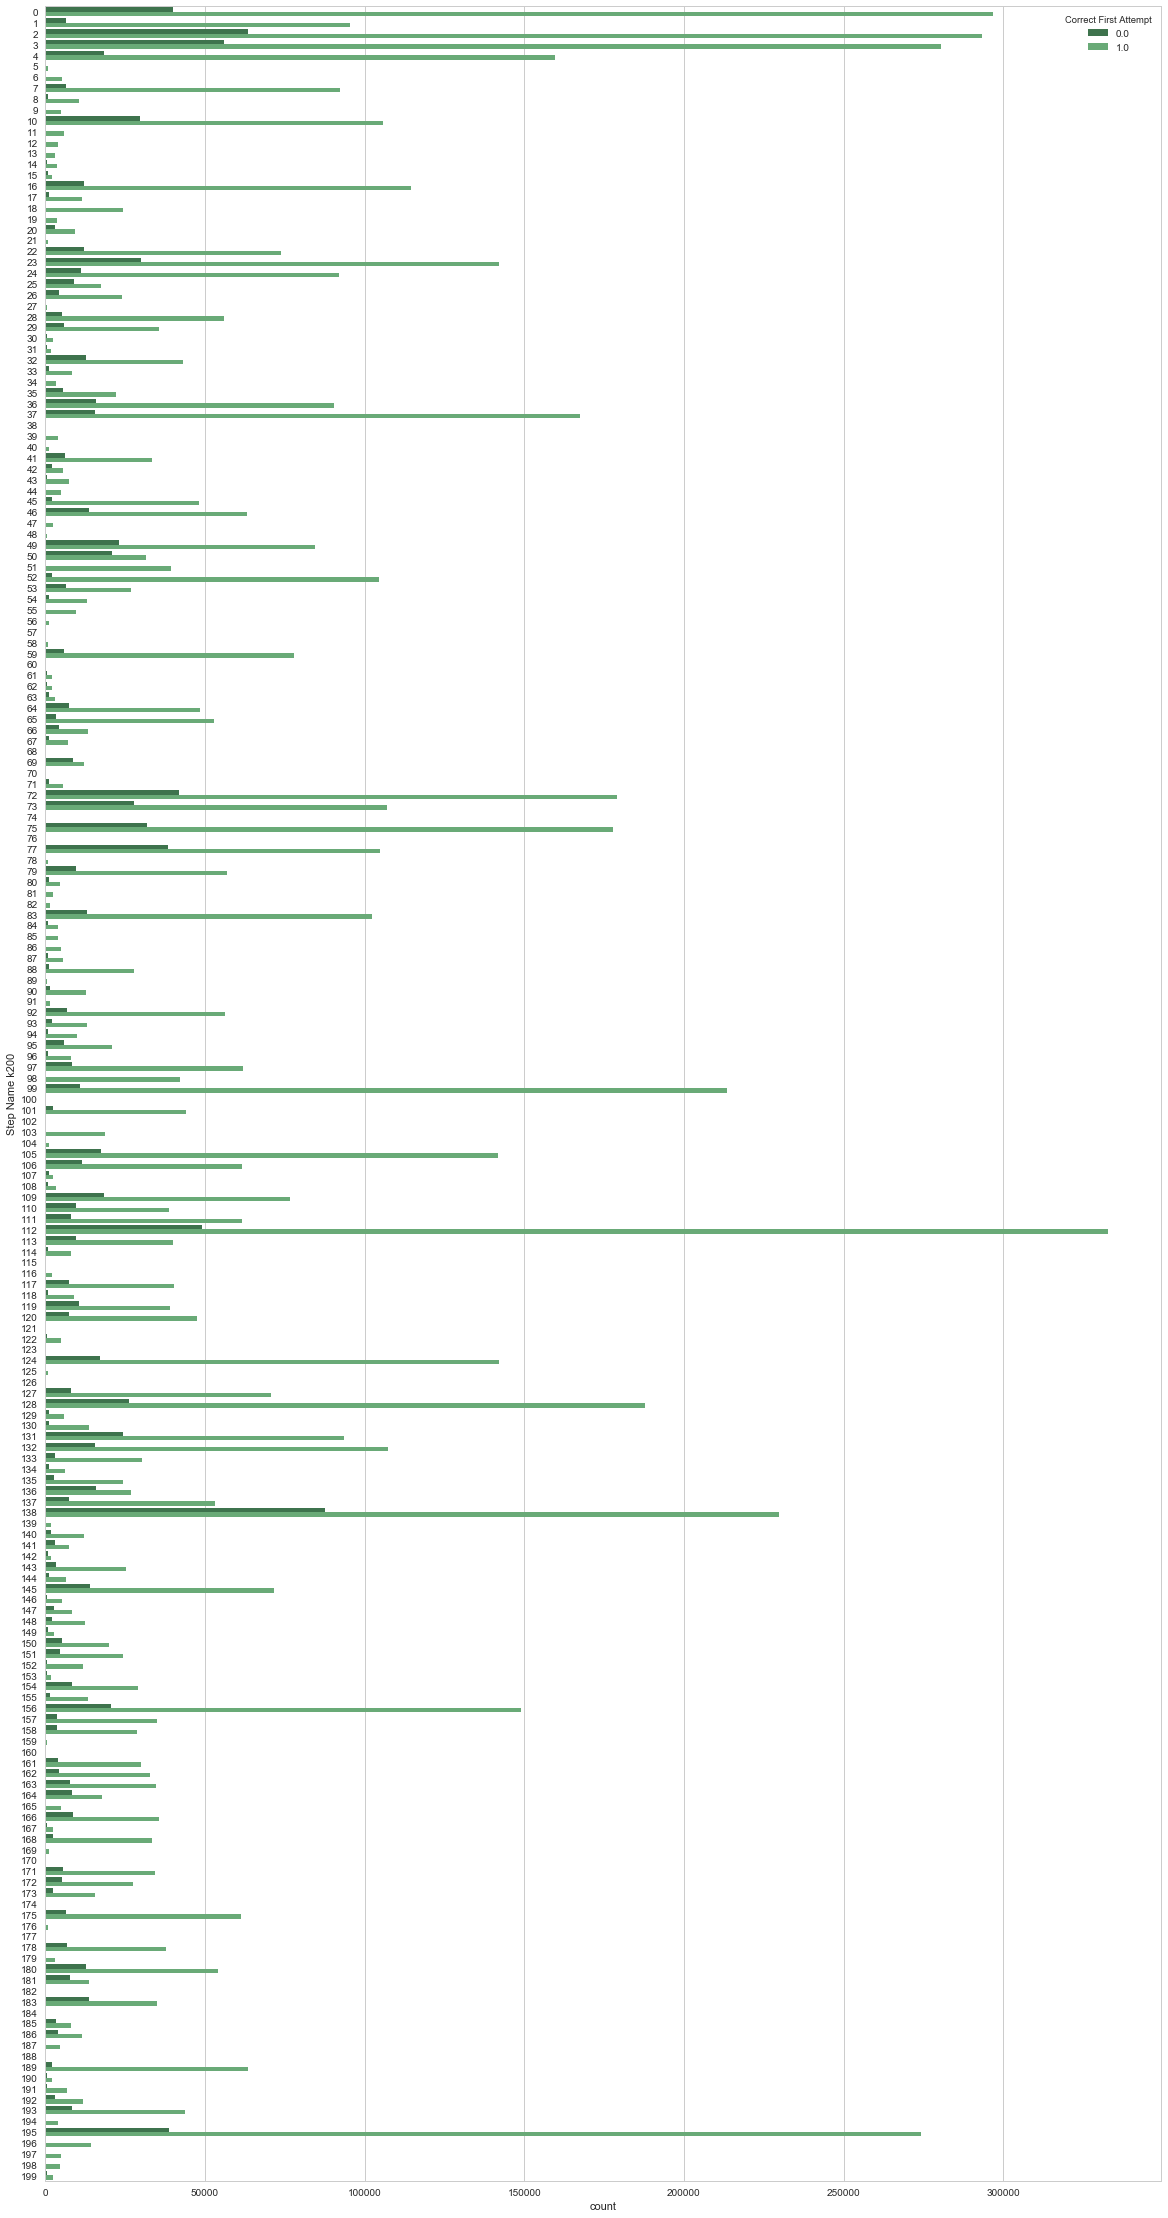

In [20]:
sns.set(style="whitegrid", color_codes=True)

f, ax = plt.subplots(figsize=(20, 40))
sns.countplot(y="Step Name k200", hue="Correct First Attempt", data=data_train_loaded, palette="Greens_d");

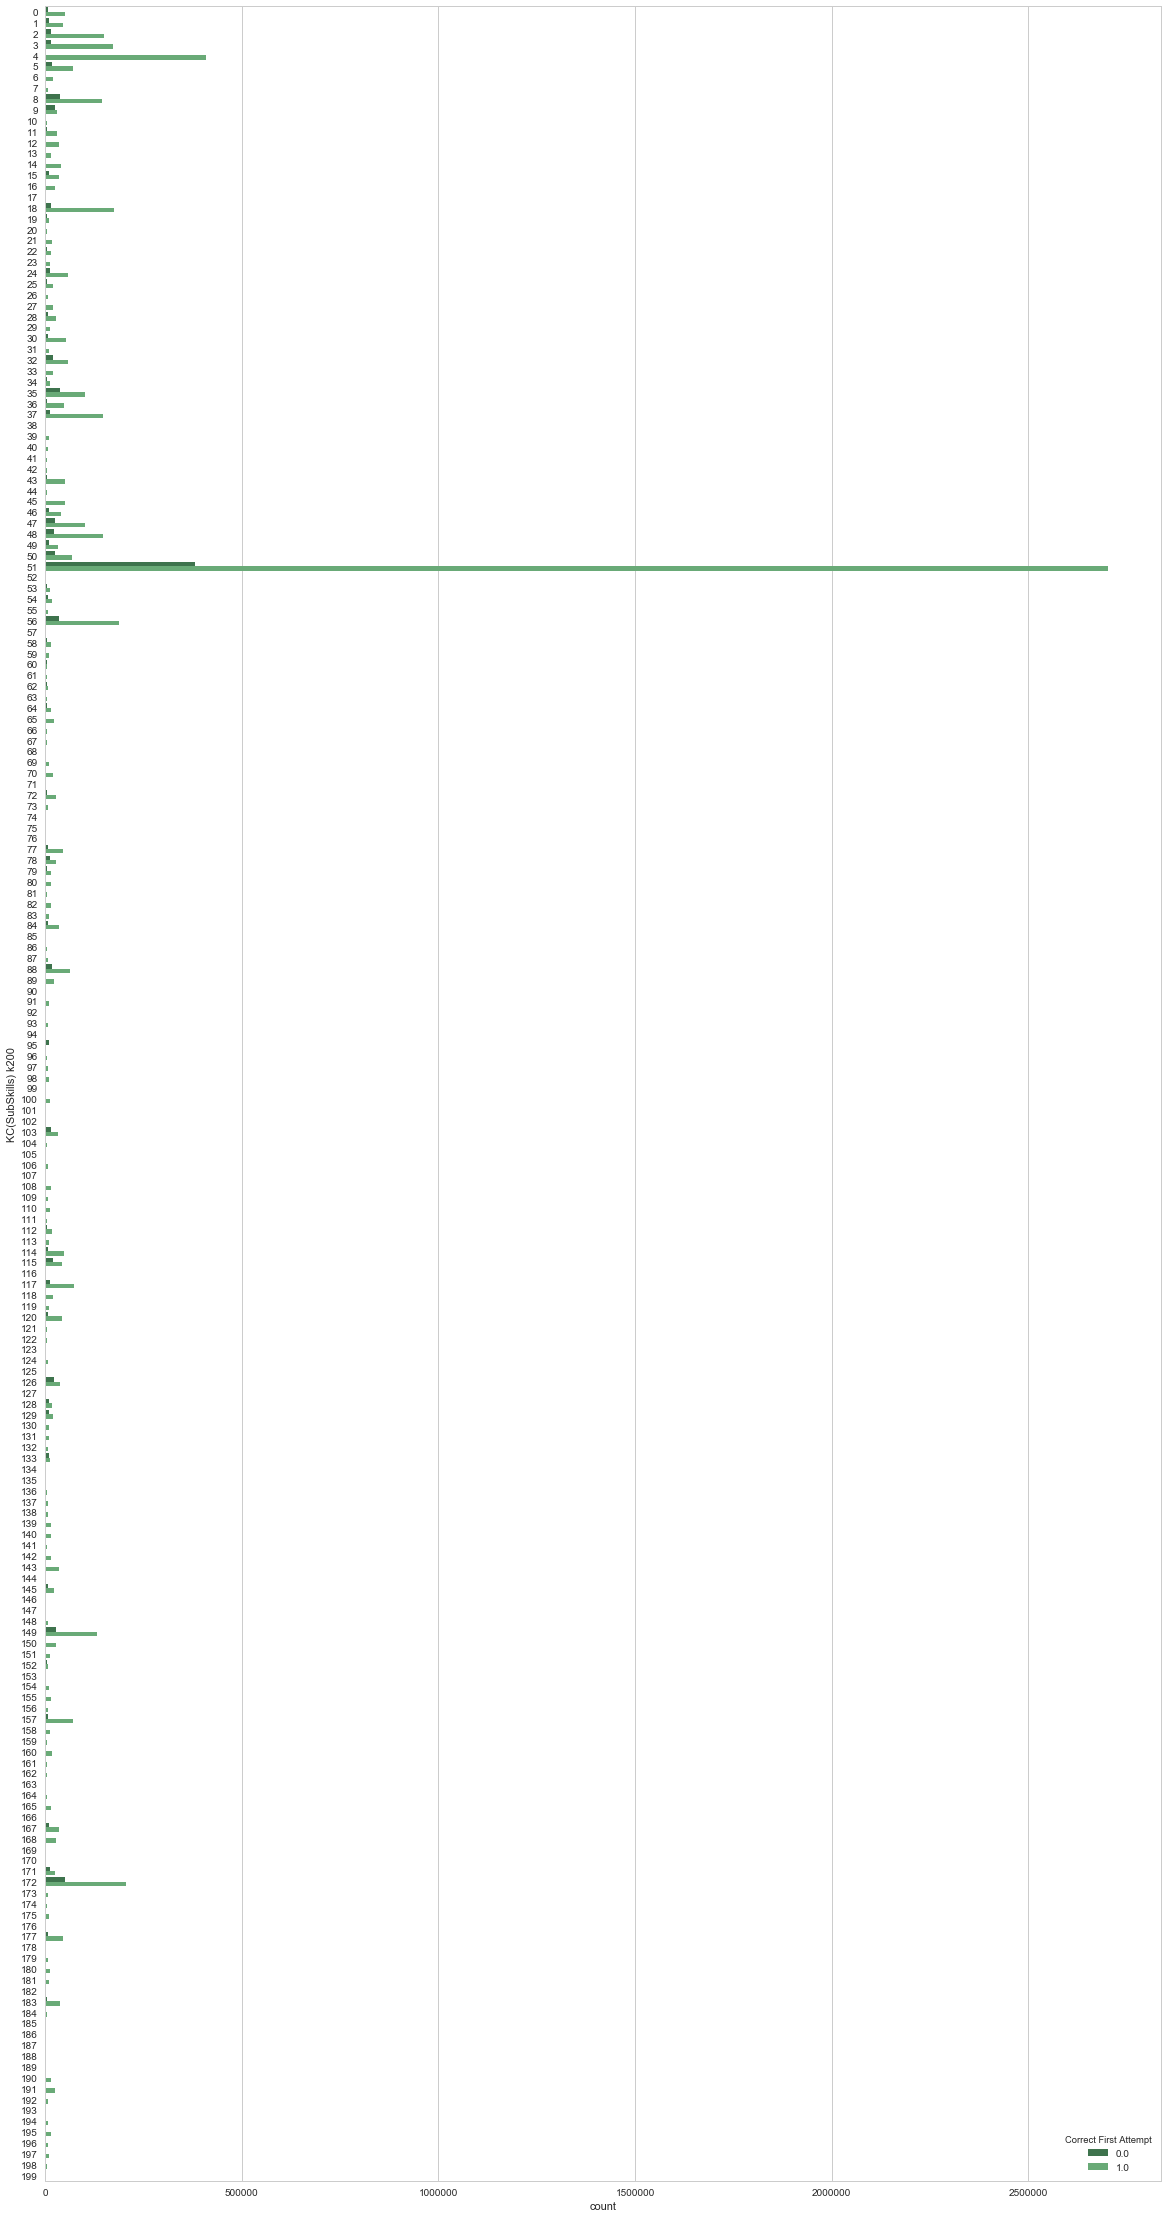

In [21]:
sns.set(style="whitegrid", color_codes=True)

f, ax = plt.subplots(figsize=(20, 40))
sns.countplot(y="KC(SubSkills) k200", hue="Correct First Attempt", data=data_train_loaded, palette="Greens_d");

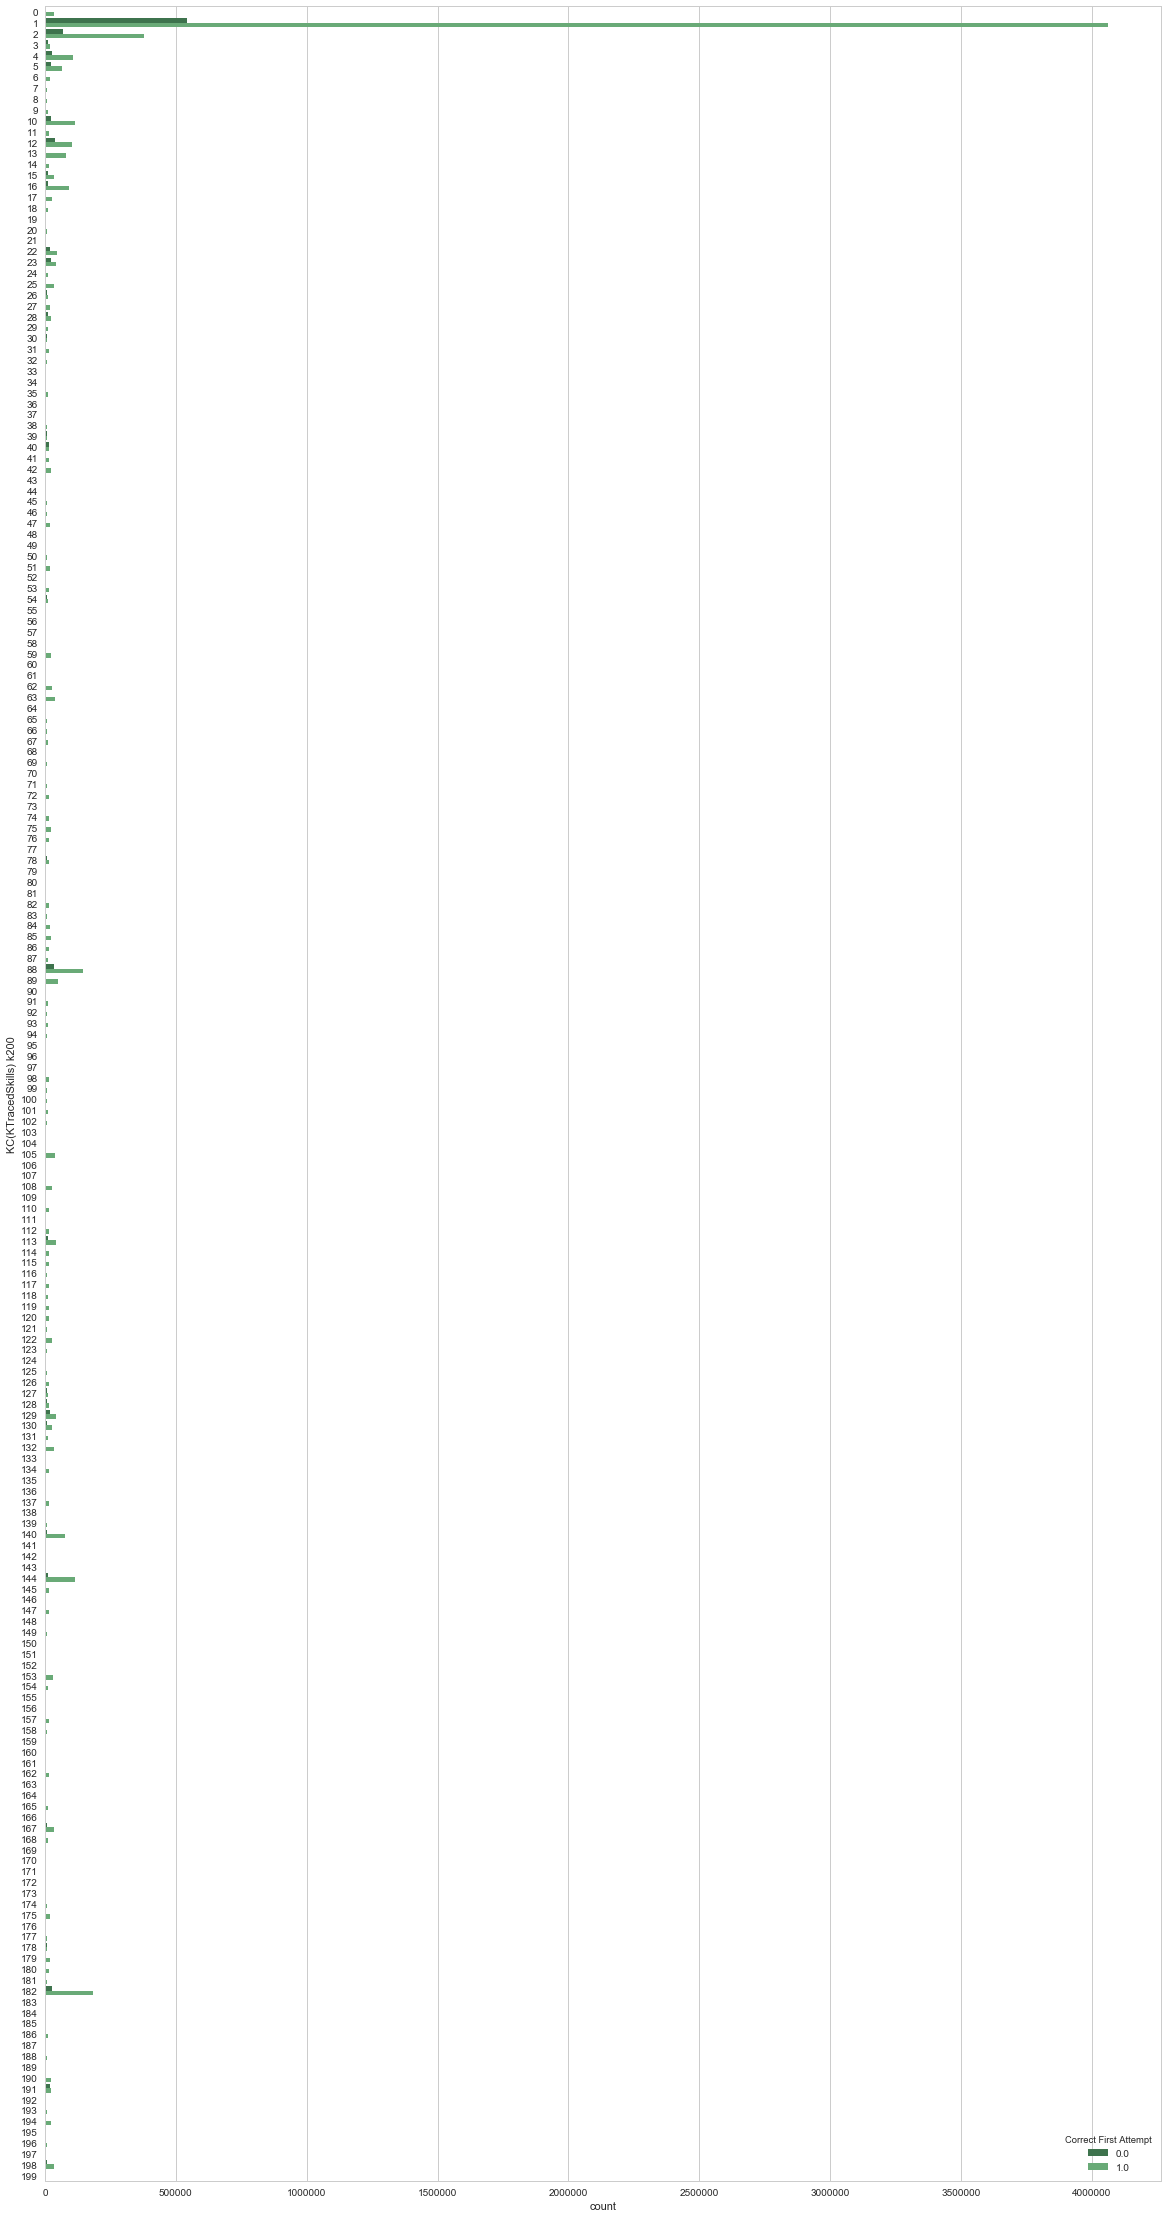

In [22]:
sns.set(style="whitegrid", color_codes=True)

f, ax = plt.subplots(figsize=(20, 40))
sns.countplot(y="KC(KTracedSkills) k200", hue="Correct First Attempt", data=data_train_loaded, palette="Greens_d");

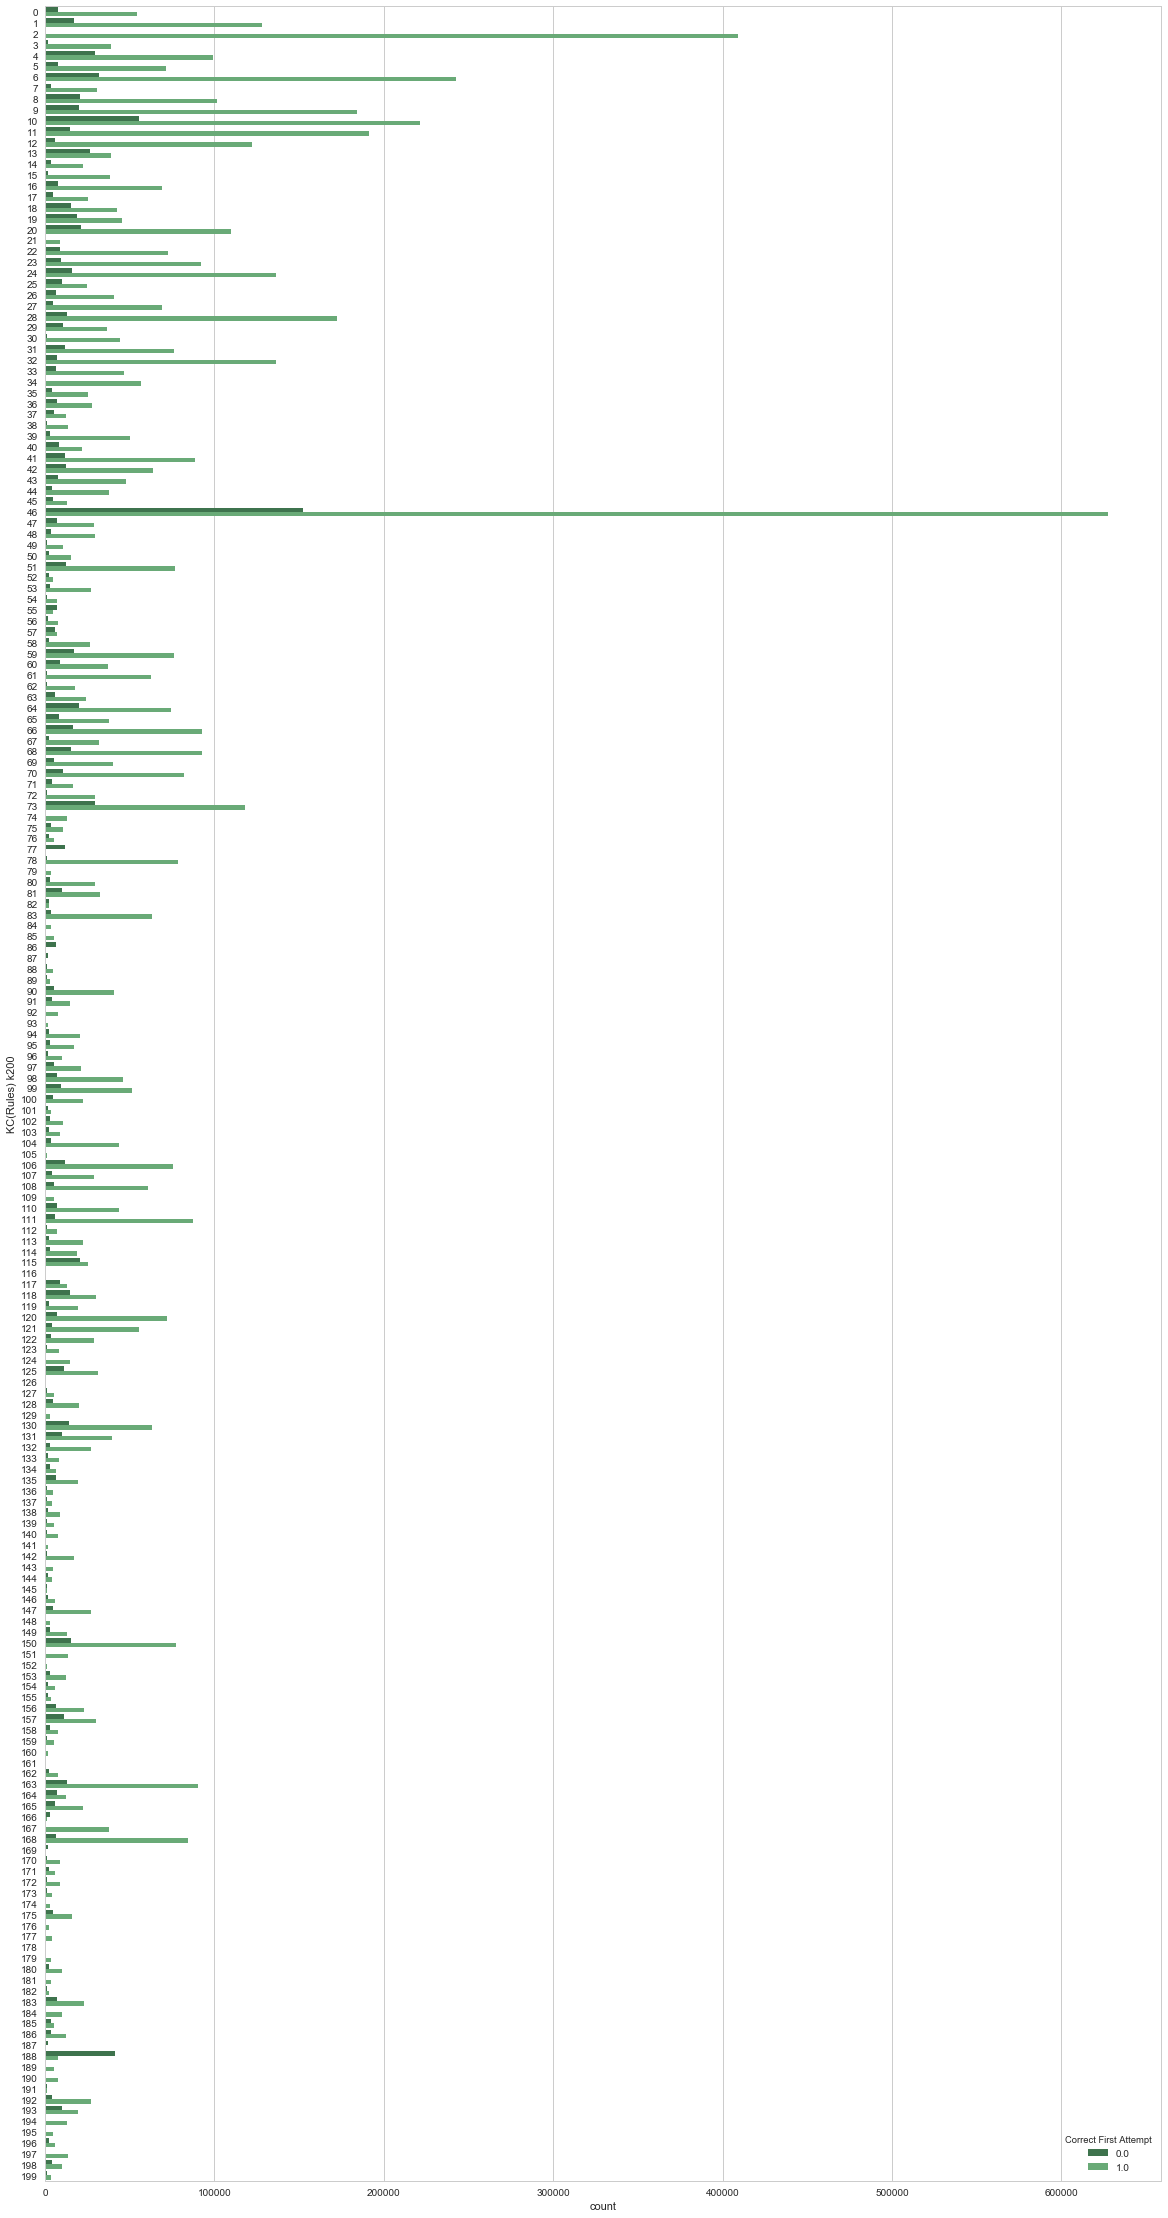

In [23]:
sns.set(style="whitegrid", color_codes=True)

f, ax = plt.subplots(figsize=(20, 40))
sns.countplot(y="KC(Rules) k200", hue="Correct First Attempt", data=data_train_loaded, palette="Greens_d");

## Analysis: Benchmark

    print("start printing to file")
    outputfile = open("" + current_set + "_all_ones.txt","w") 
    outputfile.write("Row\tCorrect First Attempt\n")

    for i in range(num_test_records):
        outputfile.write("%s\t%i\n" % (data_test.loc[i]['Row'], 1))

    outputfile.close()
    print("done printing to file")

***

## Unoptimized Model

***

## Optimized Model

In [ ]:
## from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import PassiveAggressiveClassifier
#from sklearn.linear_model import RidgeClassifier, SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

print "Start optimized training"

RANDOM_STATE = 10
skfolds = 4
batch_size = num_train_records/skfolds

print "batch size: %i" % batch_size
print "skfolds: %i" % skfolds

# Column options
# Problem Name k100 k200
# Step Name k100 k200
# KC(SubSkills) k200
# KC(KTracedSkills) k100 k200
# KC(Rules) k100 k200
cfeatures = ['Problem Name Cat k200','Step Name k100','KC(SubSkills) k100','KC(KTracedSkills) k200','KC(Rules) k200']
X_train = data_train_loaded[cfeatures].copy()
y_train = data_train_loaded['Correct First Attempt']

# for fast testing
#tmprecords = 1000000
#X_train = X_train[0:tmprecords]
#y_train = y_train[0:tmprecords]

# I am not using these, but am leaving them in to show other classifiers I tried. None 
# of them performed as well as Random Tree
#clf = linear_model.LogisticRegression(random_state=RANDOM_STATE, class_weight={ 0:neg_weight_train, 1:pos_weight_train })
#clf = PassiveAggressiveClassifier(C=100,n_iter=5,random_state=RANDOM_STATE, class_weight={ 0:neg_weight_train, 1:pos_weight_train })
#clf = RidgeClassifier(random_state=RANDOM_STATE, class_weight={ 0:neg_weight_train, 1:pos_weight_train })
#clf = SGDClassifier(eta0=1, learning_rate="constant", random_state=RANDOM_STATE, class_weight={ 0:neg_weight_train, 1:pos_weight_train })


# Make a mean_squared_error scoring object
scorer = make_scorer(mean_squared_error, greater_is_better=False)

select = SelectKBest()
clf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight={ 0:neg_weight_train, 1:pos_weight_train })

steps = [('feature_selection', select),
         ('classifier', clf)]

pipeline = Pipeline(steps)

#parameters = {'n_estimators':[30], \
#              'min_samples_split':[7], \
#              'min_samples_leaf':[50], \
#              'min_impurity_split':[1e-06,1e-07] \
#              }

parameters = dict(feature_selection__k=[4],
                  classifier__criterion=["entropy"],
                  classifier__n_estimators=[20],
                  classifier__min_samples_leaf=[2],
                  classifier__min_samples_split=[5],
                  classifier__min_impurity_split=[1e-07]
                 )

#from sklearn.cross_validation import ShuffleSplit
#cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 6, test_size = 0.20, random_state = 0)

# Perform grid search on the classifier using 'scorer' as the scoring method, StratifiedKFold as cv
#model = GridSearchCV(pipeline, param_grid=parameters, scoring=scorer, cv=cv_sets)

#print "start fitting model %s %s" % (cfeatures, str(datetime.now()))
#model.fit(X_train, y_train)
#print "done fitting model %s" % str(datetime.now())

#print model
#print "\n"
#print model.best_estimator_
#print "Best score: %f " % model.best_score_
#print "Done with optimized training"


model = GridSearchCV(pipeline, param_grid=parameters, scoring=scorer, cv=skfolds, verbose=1)

print "start fitting model %s %s" % (cfeatures, str(datetime.now()))
model.fit(X_train, y_train)
print "done fitting model %s" % str(datetime.now())

#print model
print "\n"
print model.best_estimator_
print "Best score: %f " % model.best_score_
print "Done with optimized training"

In [ ]:
# Get the predictions on the test set
X_test = data_test_loaded[cfeatures]

print "start predictions using %s %s" % (cfeatures, str(datetime.now()))
predictions_test = model.predict(X_test)
print "done with predictions %s" % str(datetime.now())

#print("Y test:")
#print list(predictions_test)
outputfile = open("" + current_set + "-" + datetime.now().strftime('%m-%d-%H-%M') + ".txt","w") 
outputfile.write("Row\tCorrect First Attempt\n")

for i,item in enumerate(predictions_test):
    outputfile.write("%s\t%i\n" % (data_test.loc[i]['Row'], item))
    
outputfile.close()
       
# Success
print "Done with testing using optimized model"

### Final Solution Scores



***